In [1]:

import numpy as np 
from TRIOMA.tools.component_tools import Component
from TRIOMA.tools.component_tools import Fluid
from TRIOMA.tools.component_tools import Membrane
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from TRIOMA.tools.component_tools import BreedingBlanket
import mph 
from TRIOMA.tools.component_tools import Geometry
inv_v=[]
inv_v_comsol=[]
scatter_mat = np.empty((0, 9))


In [2]:
K_H_vec=np.logspace(-4,-1,4)
K_S_vec=np.logspace(-4,-1,4)
D_vec=np.logspace(-10,-6,5)
# K_H_vec=[1E-1]
# D_vec=[1E-10]
# K_S_vec=[1E-4]
count=0
for K_H in K_H_vec:
        for K_S in K_S_vec:
                for D in D_vec:
                        count+=1
                        print("Iteration",str(count) ,"of",len(K_H_vec)*len(K_S_vec)*len(D_vec))
                        U0=1.5
                        eff_coms_v=np.array([])
                        eff_py=np.array([])
                        client = mph.start()
                        compute_comsol=True
                        # U0=1.5
                        T=800
                        p_out=0
                        c0=1E-3
                        mat=materials.Flibe(T)
                        T_hot_prim=900
                        T_cold_prim=800
                        Q=1E9
                        d_hyd=1E-2
                        L=8
                        # D=1E-4
                        thick=2E-3
                        # K_S=1
                        k_d=1E6
                        k_r=1E6
                        # K_H=20
                        flibe=Fluid(T=T, Solubility=K_H, MS=True,D=mat.D*1E1, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=U0,k=mat.k,cp=mat.cp)
                        
                        Steel = Membrane( T=T,
                                D=D,
                                thick=thick,
                                K_S=K_S,
                                k_d=k_d,
                                k_r=k_r,k=21)
                        geom_pav=Geometry(L=L, D=d_hyd,thick=thick , n_pipes=1)
                        PAV = Component(c_in=c0,  fluid=flibe, membrane=Steel,geometry=geom_pav)
                        inv=PAV.get_solid_inventory(p_out=p_out)
                        PAV.use_analytical_efficiency()
                        var_vec=[T,c0,d_hyd,L,D,thick,K_S,K_H,mat.D*1E1,U0,p_out**0.5*PAV.membrane.K_S]
                        var_vec_str=['T','c0','d_hyd','L','D_St','thick','K_S','K_H','D_flibe','U0','cext']
                        if compute_comsol:
                                client = mph.start()
                                if PAV.fluid.MS: 
                                        
                                        model = client.load('PAV_MS_2species_SST_copia.mph')  
                                else: 
                                        model = client.load('PAV_LM_SST.mph')
                                for i,var in enumerate(var_vec):
                                        model.parameter(var_vec_str[i], str(var))
                                model.mesh()
                                
                                a=model.parameters()
                                # model.save()
                                # print("Saved")
                                model.solve()
                                # Evaluate the results
                                inv_coms_vec = model.evaluate(['r', 'z', 'inv'], 'Study 1//Solution 1')
                                inv_coms_f_vec=model.evaluate(['r', 'z', 'inv_fluid'], 'Study 1//Solution 1')
                                eff_coms_vec = model.evaluate(['r', 'z', 'eff'], 'Study 1//Solution 1')
                                # Remove NaN values from the 'inv' component
                                inv_values = inv_coms_vec[-1]  # Assuming 'inv' is the last component
                                inv_values = inv_values[~np.isnan(inv_values)]
                                inv_coms_f=inv_coms_f_vec[-1]
                                inv_coms_values_f=inv_coms_f[~np.isnan(inv_coms_f)]
                                eff_coms_values = eff_coms_vec[-1]
                                eff_coms_values = eff_coms_values[~np.isnan(eff_coms_values)]
                                # Calculate the average of the cleaned 'inv' values
                                
                                inv_coms_s = np.average(inv_values)
                                inv_coms_f=np.average(inv_coms_values_f)
                                eff_coms_avg = np.average(eff_coms_values)
                                
                        else: 
                                eff_coms_avg=4.22E-6
                                # Append the average to the eff_coms_v array
                        if compute_comsol:
                                k_t_coms=model.evaluate(['r', 'z', 'k_t'], 'Study 1//Solution 1')
                                k_t_values=k_t_coms[-1]
                                k_t_values=k_t_values[~np.isnan(k_t_values)]
                                k_t_avg=np.average(k_t_values)
                                print("Trioma k_t=",PAV.fluid.k_t,"Comsol k_t=",k_t_avg)
                                PAV.fluid.k_t=abs(k_t_avg)
                                PAV.get_solid_inventory(p_out=p_out)
                                inv_s=PAV.membrane.inv
                                PAV.get_fluid_inventory(p_out=p_out)
                                inv_f=PAV.fluid.inv
                                PAV.use_analytical_efficiency()
                                eff=PAV.eff
                                err_inv_s=abs(inv_s-inv_coms_s)/min(inv_s,inv_coms_s)
                                err_inv_f=abs(inv_f-inv_coms_f)/min(inv_f,inv_coms_f)
                                err_eff=abs(eff-eff_coms_avg)/min(eff,eff_coms_avg)
                                print("PAV solid inv", (PAV.membrane.inv), "Coms=", inv_coms_s, "%", "diff=", PAV.membrane.inv - inv_coms_s, "%", "rel_diff=", err_inv_s*100, "%")
                                print("PAV fluid inv", (PAV.fluid.inv), "Coms=", inv_coms_f, "%", "diff=", PAV.fluid.inv - inv_coms_f, "%", "rel_diff=", err_inv_f*100, "%")
                                print("PAV eff", (PAV.eff), "Coms=", eff_coms_avg, "%", "diff=", PAV.eff - eff_coms_avg, "%", "rel_diff=", err_eff*100, "%")
                                
                                new_row=np.array([K_H,K_S,D,inv_s,err_inv_s,inv_f,err_inv_f,eff,err_eff])
                                scatter_mat = np.vstack((scatter_mat, new_row))  # Append the new row
                                # Append the PAV membrane inventory to the eff_py array
                                client.remove(model)
                        inv_v.append(PAV.membrane.inv)
                        inv_v_comsol.append(eff_coms_avg)
                        PAV.get_solid_inventory(p_out=p_out,flag_an=True)    

Iteration 1 of 80
Trioma k_t= 0.0001523983339143446 Comsol k_t= -0.00020235189428667583
PAV solid inv 8.475284500712859e-08 Coms= 8.480320570759111e-08 % diff= -5.036070046252428e-11 % rel_diff= 0.05942066069674525 %
PAV fluid inv 6.283122248324148e-07 Coms= 6.288300681990103e-07 % diff= -5.178433665955068e-10 % rel_diff= 0.08241815870025886 %
PAV eff 2.004920781717434e-05 Coms= 2.0068040630708882e-05 % diff= -1.8832813534540527e-08 % rel_diff= 0.0939329558867067 %
Iteration 2 of 80
Trioma k_t= 0.0001523983339143446 Comsol k_t= 0.00012486884052053619
PAV solid inv 8.471900751148957e-08 Coms= 8.476577907138344e-08 % diff= -4.677155989386379e-11 % rel_diff= 0.055207870426858624 %
PAV fluid inv 6.282541666357576e-07 Coms= 6.287569428151615e-07 % diff= -5.027761794039565e-10 % rel_diff= 0.08002751212877361 %
PAV eff 0.0002004122543923792 Coms= 0.0002005888759921033 % diff= -1.766215997240923e-07 % rel_diff= 0.0881291417331656 %
Iteration 3 of 80
Trioma k_t= 0.0001523983339143446 Comsol k_t

In [3]:
scatter_mat[:,0]=np.log10(scatter_mat[:,0])
scatter_mat[:,1]=np.log10(scatter_mat[:,1])
scatter_mat[:,2]=np.log10(scatter_mat[:,2])
scatter_mat[:,4]=scatter_mat[:,4]*100
scatter_mat[:,6]=scatter_mat[:,6]*100
scatter_mat[:,7]=scatter_mat[:,7]*100
scatter_mat[:,8]=scatter_mat[:,8]*100

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_15652\1181227035.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


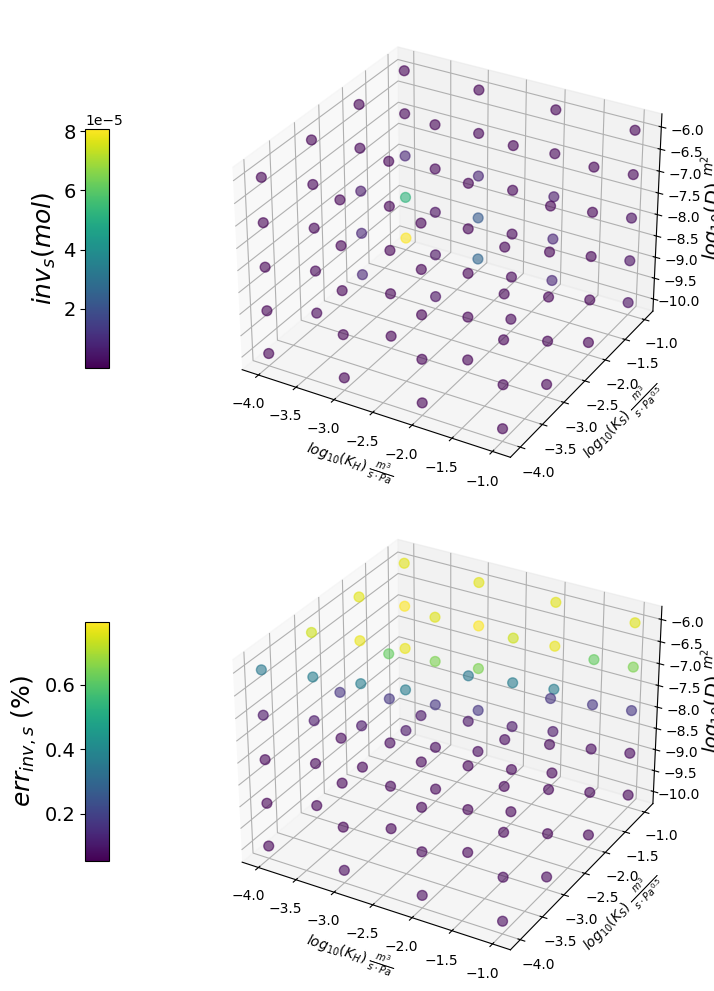

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
cmap = cm.get_cmap('viridis')
norm1 = plt.Normalize(vmin=abs(scatter_mat[:, 3]).min(), vmax=abs(scatter_mat[:, 3]).max())
norm2 = plt.Normalize(vmin=abs(scatter_mat[:, 4]).min(), vmax=abs(scatter_mat[:, 4]).max())
colors1 = np.array([
    (1, 0, 0, 1) if value > 5 else cmap(norm1(value))  # (1, 0, 0, 1) is red in RGBA
    for value in abs(scatter_mat[:, 3])
])
colors2 = np.array([
    cmap(norm2(value))  # Normalize based on scatter_mat[:, 4]
    for value in abs(scatter_mat[:, 4])
])
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

# First subplot
sc1 = ax1.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors1, s=50, alpha=0.6)
cbar1 = plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax1, shrink=0.5, aspect=10,location='left')
cbar1.set_label(r'$inv_s (mol)$',fontsize=18)
cbar1.ax.tick_params(labelsize=14)
# Set ticks in colorbar according to scatter_mat[:, 3]
# cbar1.set_ticks(np.round(np.linspace(abs(scatter_mat[:, 3]).min(), abs(scatter_mat[:, 3]).max(), num=5), 2))
# Second subplot
sc2 = ax2.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors2, s=50, alpha=0.6)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax2, shrink=0.5, aspect=10,location='left')
cbar2.set_label(r'$err_{inv,s}$ (%)', fontsize=18)
# Set ticks in colorbar according to scatter_mat[:, 4]
# cbar2.set_ticks(np.linspace(abs(scatter_mat[:, 4]).min(), abs(scatter_mat[:, 4]).max(), num=5).astype(int))
cbar2.ax.tick_params(labelsize=14)
### add labels
if PAV.fluid.MS:
    ax1.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax1.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$') 
ax1.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax1.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
if PAV.fluid.MS:
    ax2.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax2.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
## change xscale to log

##set scale limits

plt.tight_layout()
if PAV.fluid.MS:
    plt.savefig('MS_PAV_verification_solid_inventory.png', dpi=300)
else:
    plt.savefig('LM_PAV_verification_solid_inventory.png', dpi=300)
# plt.savefig('lm_GLC_verification.png', dpi=300)
plt.show()

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_15652\2557452813.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


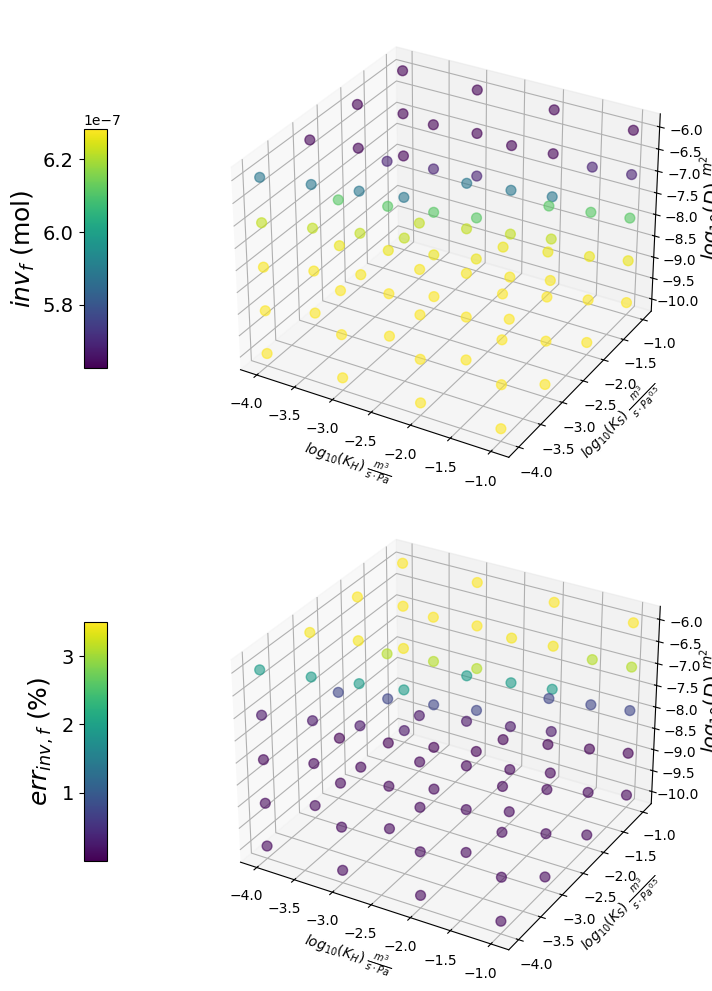

In [5]:
cmap = cm.get_cmap('viridis')
norm1 = plt.Normalize(vmin=abs(scatter_mat[:, 5]).min(), vmax=abs(scatter_mat[:, 5]).max())
norm2 = plt.Normalize(vmin=abs(scatter_mat[:, 6]).min(), vmax=abs(scatter_mat[:, 6]).max())
colors1 = np.array([
    (1, 0, 0, 1) if value > 5 else cmap(norm1(value))  # (1, 0, 0, 1) is red in RGBA
    for value in abs(scatter_mat[:, 5])
])
colors2 = np.array([
    cmap(norm2(value))  # Normalize based on scatter_mat[:, 4]
    for value in abs(scatter_mat[:, 6])
])
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
# First subplot

sc1 = ax1.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors1, s=50, alpha=0.6)
cbar1 = plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax1, shrink=0.5, aspect=10,location='left')
cbar1.set_label(r'$inv_f$ (mol)',fontsize=18)
cbar1.ax.tick_params(labelsize=14)
# Set ticks in colorbar according to scatter_mat[:, 3]
# cbar1.set_ticks(np.round(np.linspace(abs(scatter_mat[:, 5]).min(), abs(scatter_mat[:, 5]).max(), num=5)))
# Second subplot
sc2 = ax2.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors2, s=50, alpha=0.6)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax2, shrink=0.5, aspect=10,location='left')
cbar2.set_label(r'$err_{inv,f}$ (%)', fontsize=18)
# Set ticks in colorbar according to scatter_mat[:, 4]
# cbar2.set_ticks(np.linspace(abs(scatter_mat[:, 6]).min(), abs(scatter_mat[:, 6]).max(), num=5).astype(int))
cbar2.ax.tick_params(labelsize=14)
### add labels
if PAV.fluid.MS:
    ax1.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax1.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$') 
ax1.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax1.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
if PAV.fluid.MS:
    ax2.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax2.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
plt.tight_layout()
if PAV.fluid.MS:
    plt.savefig('MS_PAV_verification_fluid_inventory.png', dpi=300)
else:
    plt.savefig('LM_PAV_verification_fluid_inventory.png', dpi=300)
# plt.savefig('lm_GLC_verification.png', dpi=300)
plt.show()

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_15652\4047838589.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


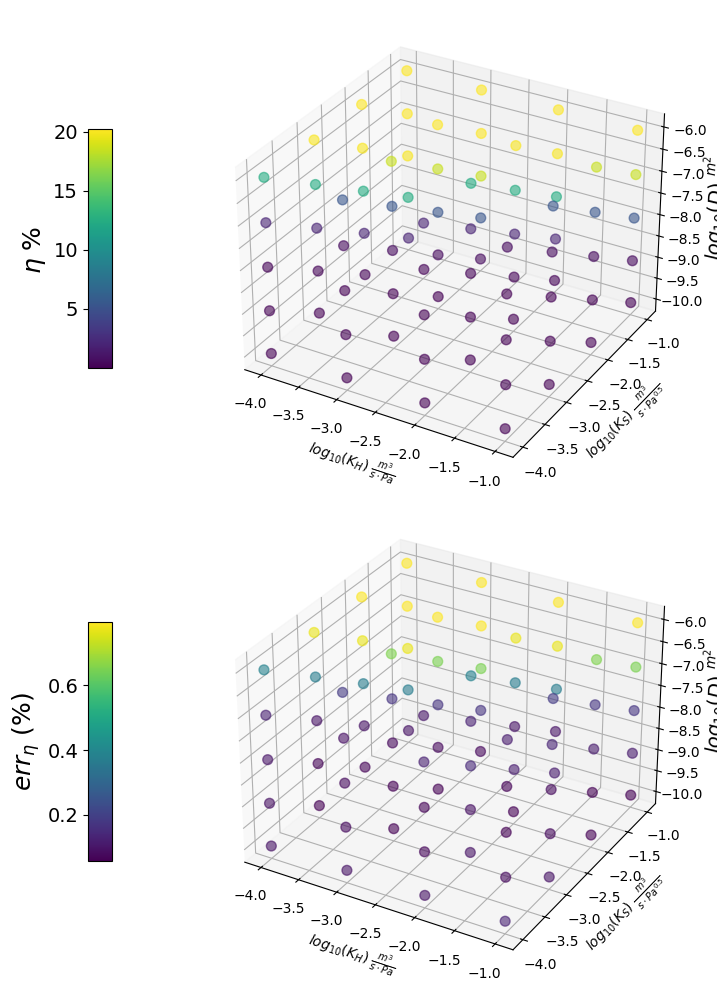

In [6]:
cmap = cm.get_cmap('viridis')
norm1 = plt.Normalize(vmin=abs(scatter_mat[:, 7]).min(), vmax=abs(scatter_mat[:, 7]).max())
norm2 = plt.Normalize(vmin=abs(scatter_mat[:, 8]).min(), vmax=abs(scatter_mat[:, 8]).max())
colors1 = np.array([cmap(norm1(value))  # (1, 0, 0, 1) is red in RGBA
    for value in abs(scatter_mat[:, 7])
])
colors2 = np.array([
    cmap(norm2(value))  # Normalize based on scatter_mat[:, 4]
    for value in abs(scatter_mat[:, 8])
])
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
# First subplot
sc1 = ax1.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors1, s=50, alpha=0.6)
cbar1 = plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax1, shrink=0.5, aspect=10,location='left')
cbar1.set_label(r'$\eta$ $\%$ ',fontsize=18)
cbar1.ax.tick_params(labelsize=14)
# Set ticks in colorbar according to scatter_mat[:, 3]
# cbar1.set_ticks(np.round(np.linspace(abs(scatter_mat[:, 7]).min(), abs(scatter_mat[:, 7]).max(), num=5), 2))
# Second subplot
sc2 = ax2.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors2, s=50, alpha=0.6)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax2, shrink=0.5, aspect=10,location='left')
cbar2.set_label(r'$err_{\eta}$ (%)', fontsize=18)
# Set ticks in colorbar according to scatter_mat[:, 4]
# cbar2.set_ticks(np.linspace(abs(scatter_mat[:, 8]).min(), abs(scatter_mat[:, 8]).max(), num=5).astype(int))
cbar2.ax.tick_params(labelsize=14)
### add labels
if PAV.fluid.MS:
    ax1.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax1.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$') 
ax1.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax1.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
if PAV.fluid.MS:
    ax2.set_xlabel(r'$log_{10}(K_H)$ $\frac{m^3}{s\cdot Pa}$') 
else:
    ax2.set_xlabel(r'$log_{10}(K_{S,l})$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_ylabel(r'$log_{10}(K_S)$ $\frac{m^3}{s\cdot Pa^{0.5}}$')
ax2.set_zlabel(r'$log_{10}(D)$ $\frac{m^2}{s}$',fontsize=14)
plt.tight_layout()
# plt.savefig('lm_GLC_verification.png', dpi=300)
if PAV.fluid.MS:
    plt.savefig('MS_PAV_verification_efficiency.png', dpi=300)
else:
    plt.savefig('LM_PAV_verification_efficiency.png', dpi=300)
plt.show()

In [7]:
## save scatter_mat to txt
# np.savetxt('scatter_mat.txt', scatter_mat, fmt='%1.4e', delimiter=' ', header='K_H K_S D inv_s err_inv_s inv_f err_inv_f eff err_eff')